In [1]:
# settings on osc gpu
!module load cuda
!module load pytorch


The following have been reloaded with a version change:
  1) cuda/11.8.0 => cuda/10.2.89



In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
if torch.cuda.is_available():
    print(torch.cuda.get_device_properties(0))

_CudaDeviceProperties(name='Tesla V100-PCIE-16GB', major=7, minor=0, total_memory=16144MB, multi_processor_count=80, uuid=22a52d90-379f-7608-7f7f-3939cae88dfb, L2_cache_size=6MB)


In [3]:
# doc: torch.unsqueeze()
# https://pytorch.org/docs/stable/torch.html#torch.unsqueeze
# doc: torch. squeeze()
# https://pytorch.org/docs/stable/torch.html#torch.squeeze

def make_features(x):
    """build features i.e. a matrix with columns [x, x^2, x^3]"""
    x=x.unsqueeze(1)
    return torch.cat([x**i for i in range(1,4)],1)

def f(x):
    w_target = torch.FloatTensor([0.5,3,2.4]).unsqueeze(1)
    b_target = torch.FloatTensor([0.9])
    return x.mm(w_target)+b_target

def get_batch(batch_size=32):
    """builds a batch i.e. (x, f(x)) pairs"""
    random = torch.randn(batch_size)
    x = make_features(random)
    y = f(x)
    if torch.cuda.is_available:
        return Variable(x).cuda(), Variable(y).cuda()
    else:
        return Variable(x), Variable(y)

In [5]:
# define model
class PolyRegression(nn.Module):
    def __init__(self):
        super(PolyRegression,self).__init__()
        self.model=nn.Linear(3,1)
    
    def forward(self, x):
        return self.model(x)

# init model
if torch.cuda.is_available:
    model=PolyRegression().cuda()
else:
    model=PolyRegression()

In [6]:
num_epochs=10**3
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(),lr=1e-3)
for epoch in range(num_epochs):
    # forward
    batch_x, batch_y = get_batch()
    output = model(batch_x)
    loss = criterion(output, batch_y)
    #backword
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % (num_epochs/10) == 0:
        print('Epoch {:5d}/{:5d}, loss = {:.6f}'.format((epoch+1), num_epochs, loss.data))

Epoch   100/ 1000, loss = 20.296333
Epoch   200/ 1000, loss = 3.969561
Epoch   300/ 1000, loss = 0.835944
Epoch   400/ 1000, loss = 0.192312
Epoch   500/ 1000, loss = 0.081080
Epoch   600/ 1000, loss = 0.067823
Epoch   700/ 1000, loss = 0.093945
Epoch   800/ 1000, loss = 0.030801
Epoch   900/ 1000, loss = 0.028830
Epoch  1000/ 1000, loss = 0.019441


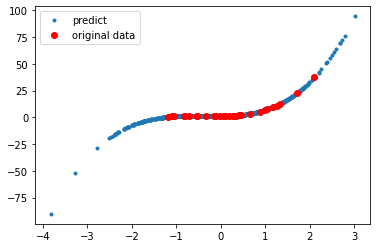

In [7]:
# print results
model.eval()
batch_x1, batch_y1 = get_batch(10**3)
predict = model(batch_x1).cpu()
predict = predict.data.numpy()
batch_x1 = batch_x1.cpu()
batch_x = batch_x.cpu()
batch_y = batch_y.cpu()
# display(batch_x[:,0])
# display(batch_y)
# display(predict)
plt.plot(batch_x1.numpy()[:,0], predict, '.', label='predict')
plt.plot(batch_x.numpy()[:,0], batch_y.numpy(),'ro', label='original data')
plt.legend()
plt.show()

In [4]:
# x_train = np.array([[3.3],[4.4],[5.5],[6.71],[6.93],[4.168],[9.779],
#                     [6.182],[7.59],[2.167],[7.042],[10.791],[5.313],[7.997],
#                     [3.1]],dtype=np.float32)
# y_train = np.array([[1.7],[2.76],[2.09],[3.19],[1.694],[1.573],
#                    [3.366],[2.596],[2.53],[1.221],[2.827],
#                    [3.465],[1.65],[2.904],[1.3]],dtype=np.float32)
# # x_train = np.array([3.3,4.4,5.5,6.71,6.93,4.168,9.779,
# #                     6.182,7.59,2.167,7.042,10.791,5.313,7.997,
# #                     3.1],dtype=np.float32)
# # y_train = np.array([1.7,2.76,2.09,3.19,1.694,1.573,
# #                    3.366,2.596,2.53,1.221,2.827,
# #                    3.465,1.65,2.904,1.3],dtype=np.float32)
# x_train = torch.from_numpy(x_train)
# y_train = torch.from_numpy(y_train)
# x_train=x_train.squeeze(1)
# y_train=y_train.squeeze(1)
# batch_x=make_features(x_train)
# batch_y=make_features(y_train)
# if torch.cuda.is_available():
#     batch_x=Variable(batch_x).cuda()
#     batch_y=Variable(batch_y).cuda()
# else:
#     batch_x=Variable(batch_x)
#     batch_y=Variable(batch_y)
# display(batch_x.size())
# display(batch_y.size())
# display(batch_x)